# LoRA Explained: Fine-Tune Large Models with 90% Fewer Parameters


<p align="right">
  <a href="https://colab.research.google.com/github/tripathysagar/sagaTrip/blob/main/nbs/02_LoRAPytorch.ipynb" target="_blank">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </a>
</p>


*A hands-on guide to Parameter-Efficient Fine-Tuning using Low-Rank Adaptation*

What if you could adapt a large neural network to new tasks while only training 7% of its parameters? Low-Rank Adaptation (LoRA) makes this possible by cleverly decomposing weight updates into smaller matrices. 

In this tutorial, we'll build LoRA from scratch using PyTorch, demonstrate it on MNIST classification, and show why it's revolutionizing how we fine-tune large language models.

**What you'll learn:**
- The mathematical intuition behind low-rank decomposition
- How to implement LoRA adapters in PyTorch
- Why LoRA prevents catastrophic forgetting
- Practical tips for hyperparameter tuning (rank, alpha)
- How to save and load multiple task-specific adapters


When we fine tune the model, we update all the paramets of the weights. Which might lead to catastrophic forgettign and overfitting. By  this method we can update only a subset of the parameters. If you are awaare of resnet block, you can think of LoRA weights are main path and the original model is the identity path. By training we eventually learn wrt the new weights added to the model.

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn

## Rank of a tensor:
No of linearly independent rows or columns. It gives of true dimension of the information of the matrix.
For LoRA, when we say "rank=8", we're forcing our adaptation to have at most rank 8, meaning it can only capture 8 independent patterns of change.

In [ ]:
rank_1 = torch.tensor([[1., 2.], [2., 4.]])
rank_2 = torch.tensor([[1., 2.], [3., 4.]])
zero_matrix = torch.zeros(3, 3)

print("Rank 1 matrix:")
print(rank_1)
print(f"Actual rank: {torch.linalg.matrix_rank(rank_1)}")

print("\nRank 2 matrix:")
print(rank_2) 
print(f"Actual rank: {torch.linalg.matrix_rank(rank_2)}")

print("\nZero matrix:")
print(f"Actual rank: {torch.linalg.matrix_rank(zero_matrix)}")


Rank 1 matrix:
tensor([[1., 2.],
        [2., 4.]])
Actual rank: 1

Rank 2 matrix:
tensor([[1., 2.],
        [3., 4.]])
Actual rank: 2

Zero matrix:
Actual rank: 0


## LoRA
Let's consider a simple case of matrix multiplication.

In [ ]:
W = torch.randn(512, 256)
x = torch.randn(2, 256)
y = x @ W.T
print(f"Input shape: {x.shape}")
print(f"Weight shape: {W.shape}")
print(f"Output shape: {y.shape}")

Input shape: torch.Size([2, 256])
Weight shape: torch.Size([512, 256])
Output shape: torch.Size([2, 512])


Low-rank decomposition means breaking down a large matrix into the product of two smaller matrices. Think of it this way:
1. Original matrix: 512×256 (rank could be up to 256)
1. Low-rank decomposition: `A(512*8) * B(8*256)`

The "rank" is the inner dimension (8 in our case). 

In [ ]:
rank = 8
A = torch.randn(512, rank)
B = torch.randn(rank, 256)
W_decomposed = A @ B
print(f"A shape: {A.shape}")
print(f"B shape: {B.shape}")
print(f"W_decomposed shape: {W_decomposed.shape}")
print(f"Parameters in original W: {W.numel()}")
print(f"Parameters in A + B: {A.numel() + B.numel()}")


A shape: torch.Size([512, 8])
B shape: torch.Size([8, 256])
W_decomposed shape: torch.Size([512, 256])
Parameters in original W: 131072
Parameters in A + B: 6144


Now we need to understand how LoRA uses this decomposition. In LoRA, we don't replace the original weight W. Instead, we ADD the low-rank adaptation to it.
```py
y_lora = x @ (W + W_decomposed).T = x @ W.T + x @ W_decomposed.T = x @ W.T + (x @ B.T) @ A.T
```


In [ ]:
y_lora = x @ (W + W_decomposed).T 
assert y.shape == y_lora.shape

In [ ]:
y_efficient = x @ W.T + (x @ B.T) @ A.T
assert y_efficient.shape == y.shape
assert torch.allclose(y_lora, y_lora)

So using matrix decompostion we can represet a higher dim matrix with a couple of lower dim matrixs. Which will be used for efficient learning. Useing the lower matrix we can fine tune bigger model in smaller gpu as they wull need smaller space. We can have many different such adapter for different tasks. There is drawback though we need aditional param to keeptack as well as the computation cost of forward pass increases.

## LoRA using pytorch's `nn.Module`

Our aim is following
1. **Train a simple neural network** on MNIST digits 3 and 4 for binary classification
2. **Freeze the original model** after training
3. **Add LoRA adapters** to the same model 
4. **Fine-tune only the LoRA parameters** on digits 7 and 8
5. **Compare performance** - showing that LoRA can adapt the model to new tasks without changing original weights

This demonstrates LoRA's key benefit: we can reuse a trained model for new tasks by only training a small number of additional parameters, while keeping the original model intact.

In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('./data', train=False, transform=transform)

len(mnist_train), len(mnist_test)

(60000, 10000)

Filtering datasets

In [ ]:
def filter_classes(typ, classes): 
    dataset = mnist_train if typ == 'train' else mnist_test
    indices = []
    for i, (_, label) in enumerate(dataset):
        if label in classes:
            indices.append(i)
    
    # Create new dataset with remapped labels
    remapped_data = []
    for i in indices:
        x, y = dataset[i]
        new_y = 0 if y == classes[0] else 1
        remapped_data.append((x, new_y))
    
    return remapped_data


train_34 = filter_classes('train', [3, 4])
test_34 = filter_classes('test', [3, 4])

len(train_34), len(test_34)

(11973, 1992)

In [ ]:
## dataloaders
dls1 = {
    'train' : DataLoader(train_34, batch_size=64, shuffle=True),
    'valid' : DataLoader(test_34 , batch_size=64)
}

### the base model

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model1 = Net()

### Trainer loop

In [ ]:
class Trainer:
    def __init__(self, dls, model, lr=0.01):
        self.dls = dls
        self.model = model
        self.optim = torch.optim.Adam(self.model.parameters(), lr=lr)
    
    def train(self, epochs=1):
        for epoch in range(epochs):
            # training loop
            self.model.train()
            train_loss = 0
            for batch_idx, (data, target) in enumerate(self.dls['train']):
                output = self.model(data)
                loss = F.cross_entropy(output, target)
                loss.backward()
                self.optim.step()
                self.optim.zero_grad()
                train_loss += loss.item()
            
            # Validation inside epoch loop
            self.model.eval()
            correct = 0

            with torch.no_grad():
                valid_loss = 0
                for data, target in self.dls['valid']:
                    output = self.model(data)
                    pred = output.argmax(dim=1)
                    correct += pred.eq(target).sum().item()
                    loss = F.cross_entropy(output, target)
                    valid_loss += loss.item()

                    
            accuracy = 100. * correct / len(self.dls['valid'].dataset)
            print(f'Epoch {epoch+1}: Train Loss: {train_loss/len(self.dls["train"]):.4f}, Valid Loss: {valid_loss/len(self.dls["valid"]):.4f} Accuracy: {accuracy:.2f}%')


In [ ]:
model1 = Net()
t = Trainer(dls=dls1, model=model1, lr=0.01)
t.train(1)

Epoch 1: Train Loss: 0.0355, Valid Loss: 0.0131 Accuracy: 99.75%


### Visualization 

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    with torch.no_grad():
        data, targets = next(iter(dataloader))
        outputs = model(data)
        predictions = outputs.argmax(dim=1)
        
        for i in range(num_samples):
            img = data[i].squeeze()
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'Pred: {predictions[i]}, True: {targets[i]}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

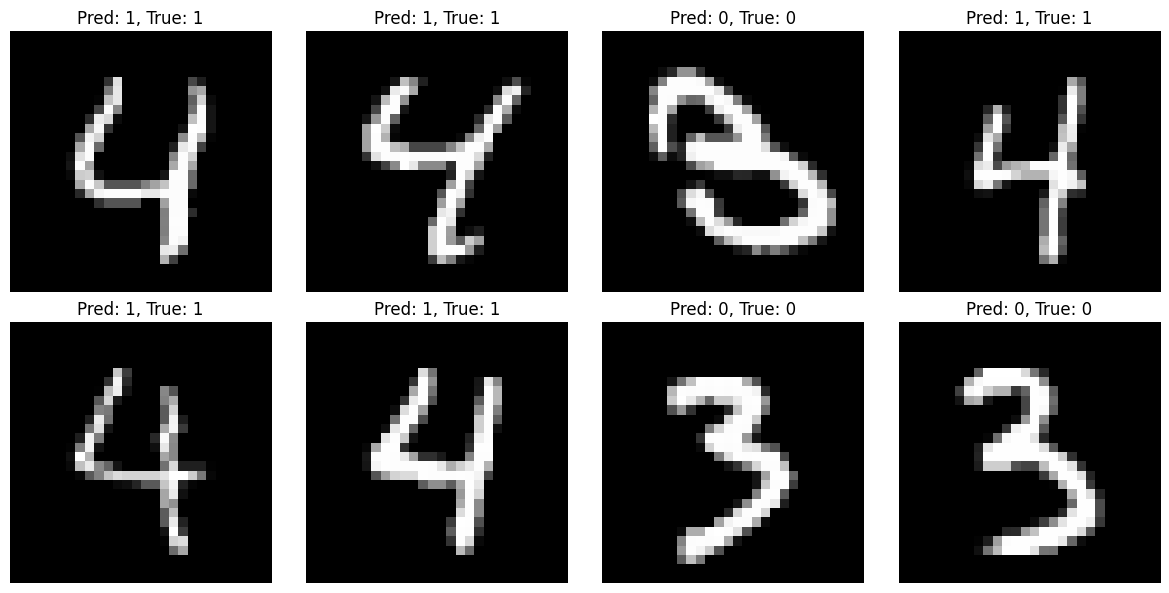

In [ ]:
visualize_predictions(model1, dls1['valid'])

We trined for 3 and 4 and got around 99% accurecy. Let's move on to using LoRA using Model1 to classification of 7 and 8.

### LoRA classification of `7` and `8`

In [ ]:
train_78 = filter_classes('train', [7, 8])
test_78 = filter_classes('test', [7, 8])

len(train_78), len(test_78)

(12116, 2002)

In [ ]:
dls2 = {
    'train' : DataLoader(train_78, batch_size=64, shuffle=True),
    'valid' : DataLoader(test_78, batch_size=64)
}

In [ ]:
x, y = next(iter(dls2['train']))
print(f"Batch shape: {x.shape}, Labels shape: {y.shape}")
model1

Batch shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])


Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

### LoRA model for Linear layers

In [ ]:
class LoRALinear(nn.Module):
    def __init__(self, original_layer, rank=4, alpha=1):
        super().__init__()
        self.original_layer = original_layer
        self.rank = rank
        self.alpha = alpha
        
        # Freeze original layer
        for param in self.original_layer.parameters():
            param.requires_grad = False
            
        # LoRA parameters
        in_features = original_layer.in_features
        out_features = original_layer.out_features
        self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.01)
        self.lora_B = nn.Parameter(torch.zeros(out_features, rank))

    def forward(self, x):
        #x = x.view(x.size(0), -1)
        return  self.original_layer(x) + (x @ self.lora_A.T ) @ self.lora_B.T * (self.alpha / self.rank)

**LoRA Weight Initialization:** Looking at your code:
```py
self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.01)  # Small random values
self.lora_B = nn.Parameter(torch.zeros(out_features, rank))        # Zeros!
```
The key insight is that at initialization, we want LoRA to have zero effect:

- `lora_A` starts with small random values
- `lora_B` starts with zeros
- So `lora_A @ lora_B = small_values @ zeros = zeros`
This means initially: `original_output + 0 = original_output`


ResNet Connection Analogy 
1. Original model = identity path (stable, proven features)
1. LoRA adaptation = residual path (learns what's missing)
1. Final output = identity + residual

If both A and B started random, the initial LoRA output would be: `random_A @ random_B = large` random values. This would immediately distort the original model's good representations, forcing the optimizer to:

1. First "undo" the random noise
1. Then learn the actual adaptation
**Alpha Parameter:** controls the "strength" of the LoRA adaptation. In the forward pass:
```py
return original_layer(x) + (x @ lora_A.T) @ lora_B.T * (alpha / rank)
```
The alpha/rank scaling serves two purposes:

Scaling independence: change in rank, the adaptation strength stays consistent
Learning rate control: Higher alpha = stronger LoRA influence

### LoRA model

In [ ]:
class NetLoRA(nn.Module):
    def __init__(self, original_model, rank=4, alpha=1):
        super().__init__()
        self.layers = []
        self.fc1 = LoRALinear(original_model.fc1, rank, alpha)
        self.fc2 = LoRALinear(original_model.fc2, rank, alpha)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
model2 = NetLoRA(model1)
x, _ = next(iter(dls2['train']))
pred = model2(x)
pred.shape

torch.Size([64, 2])

In [ ]:
# Checking if the module have grad attributes.
for name, param in model2.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

fc1.lora_A: requires_grad=True
fc1.lora_B: requires_grad=True
fc1.original_layer.weight: requires_grad=False
fc1.original_layer.bias: requires_grad=False
fc2.lora_A: requires_grad=True
fc2.lora_B: requires_grad=True
fc2.original_layer.weight: requires_grad=False
fc2.original_layer.bias: requires_grad=False


In [ ]:
#Lets train using dls2 our 7 and 8 datasets with new lora model
t2 = Trainer(dls=dls2, model=model2, lr=0.01)
t2.train(5)

Epoch 1: Train Loss: 0.2800, Valid Loss: 0.0527 Accuracy: 98.15%
Epoch 2: Train Loss: 0.0249, Valid Loss: 0.0290 Accuracy: 98.85%
Epoch 3: Train Loss: 0.0190, Valid Loss: 0.0457 Accuracy: 98.35%
Epoch 4: Train Loss: 0.0192, Valid Loss: 0.0383 Accuracy: 98.40%
Epoch 5: Train Loss: 0.0150, Valid Loss: 0.0295 Accuracy: 98.90%


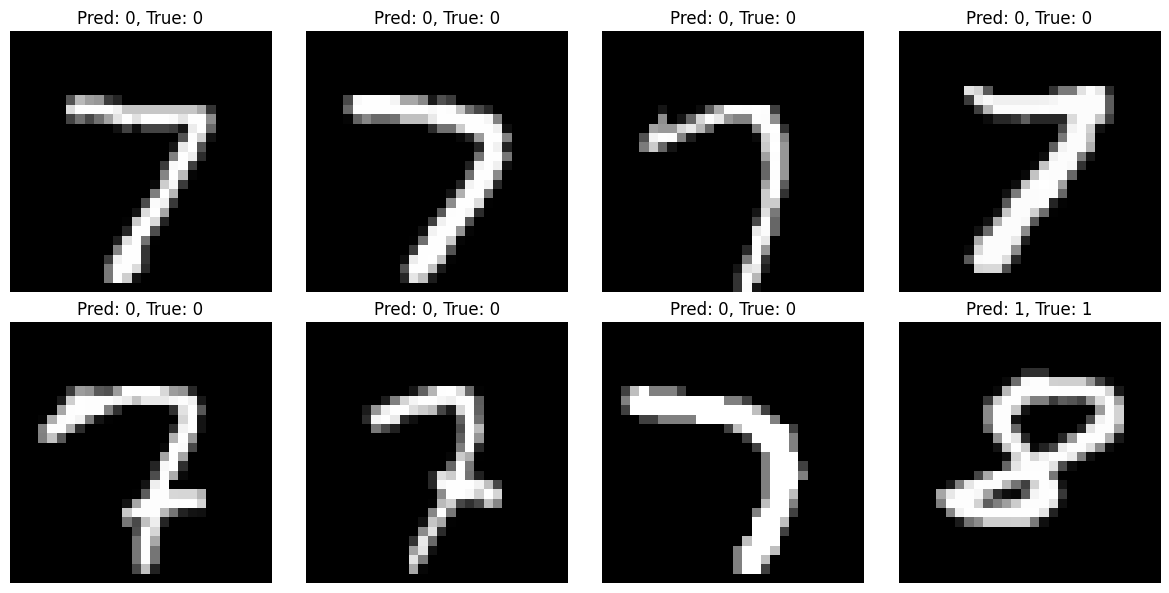

In [ ]:
# visualizing the model wrt the valid set
visualize_predictions(model2, dls2['valid'])

In [ ]:
original_params = sum(p.numel() for p in model1.parameters())
lora_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"Original model: {original_params} parameters")
print(f"LoRA adapters: {lora_params} parameters")
print(f"Efficiency: {lora_params/original_params*100:.2f}% of original")

Original model: 50370 parameters
LoRA adapters: 3656 parameters
Efficiency: 7.26% of original


### Saving LoRA weights and parameters
To save LoRA model that we specially trained. We have to save the following :
1. We need to save the hyperparameters (rank, alpha) with the LoRA weights
1. We should filter to save only requires_grad=True parameters
1. This approach allows us to have multiple LoRA adapters for different tasks
By doing the above we can save multiple LoRAs for a given base model trained for differeent task. Where each LoRA file would contain both weights and hyperparameters.

In [ ]:
# saving base model
base_model_pth = "main_model.pth"
torch.save(model1.state_dict(), base_model_pth)
!file {base_model_pth}

main_model.pth: Zip archive data, at least v0.0 to extract, compression method=store


In [ ]:
# saving lora weights 
rank, alpha = 4, 1.
lora_state = {
        'rank': rank,
        'alpha': alpha,
        'weights': {}
    }
    
for name, param in model2.named_parameters():
    # we are only filtering out the lora params whih are added
    if 'lora' in name and param.requires_grad: 
        lora_state['weights'][name] = param.data

lora_model_pth = 'lora.pth'
torch.save(lora_state, lora_model_pth )
!file {lora_model_pth}

lora.pth: Zip archive data, at least v0.0 to extract, compression method=store


Loading the LoRA model back from file

In [ ]:
# load base model
base_model = Net()
base_model.load_state_dict(torch.load(base_model_pth))
base_model

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

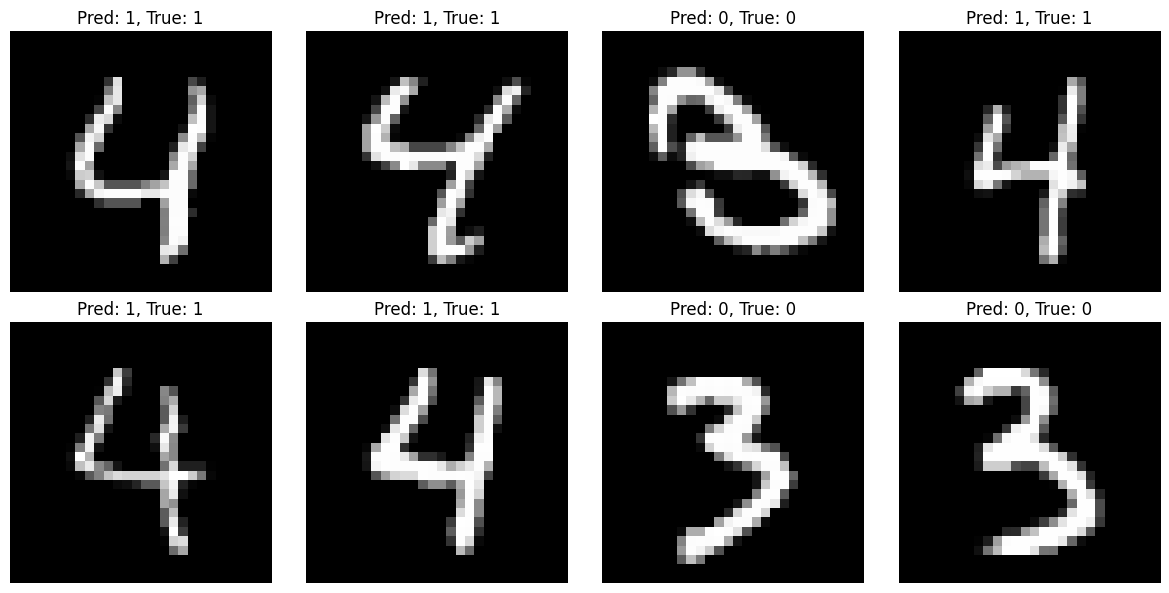

In [ ]:
visualize_predictions(base_model, dls1['valid'])

In [ ]:
# loading lora params
lora_data = torch.load(lora_model_pth)
rank = lora_data['rank']
alpha = lora_data['alpha']
rank, alpha

(4, 1.0)

In [ ]:
# Create LoRA model from base model
lora_model = NetLoRA(base_model, rank=rank, alpha=alpha)

# Then load the LoRA weights
for name, param in lora_model.named_parameters():
    if 'lora' in name and name in lora_data['weights']:
        param.data.copy_(lora_data['weights'][name])

In [ ]:
# Load LoRA weights properly
for name, param in lora_model.named_parameters():
    if 'lora' in name and name in lora_data['weights']:
        param.data.copy_(lora_data['weights'][name])


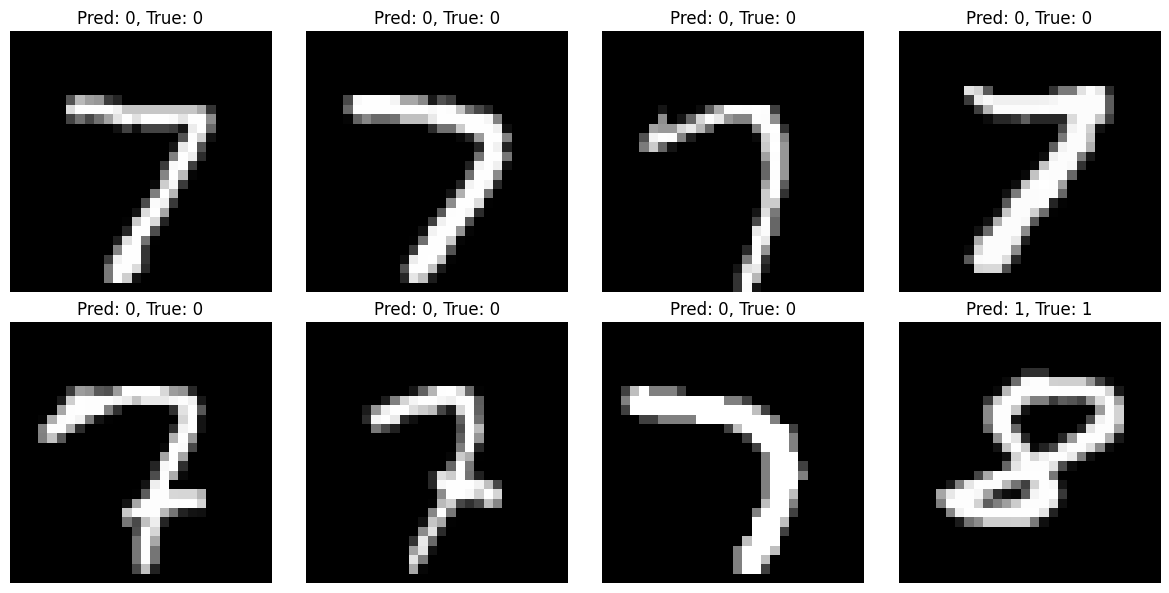

In [ ]:
# Test on 7&8 dataset
visualize_predictions(lora_model, dls2['valid'])


### Hyperparameter analysis


#### analysis of `rank`

In [ ]:
def test_rank(rank, alpha=1, epochs=3):
    print(f"\n=== Testing Rank {rank=} and {alpha=} ===")
    
    # Create LoRA model with specific rank
    lora_model = NetLoRA(model1, rank=rank, alpha=alpha)
    
    # Count parameters
    lora_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
    original_params = sum(p.numel() for p in model1.parameters())
    efficiency = lora_params/original_params*100
    
    print(f"LoRA parameters: {lora_params}")
    print(f"Efficiency: {efficiency:.2f}% of original")
    
    # Train and get final accuracy
    trainer = Trainer(dls=dls2, model=lora_model, lr=0.01)
    trainer.train(epochs)
    
    return lora_params, efficiency

# Test different ranks
ranks_to_test = [2, 4, 8, 16]
results = []

for rank in ranks_to_test:
    params, eff = test_rank(rank)
    results.append((rank, params, eff))



=== Testing Rank rank=2 and alpha=1 ===
LoRA parameters: 1828
Efficiency: 3.63% of original
Epoch 1: Train Loss: 0.3000, Valid Loss: 0.0417 Accuracy: 98.55%
Epoch 2: Train Loss: 0.0242, Valid Loss: 0.0296 Accuracy: 99.00%
Epoch 3: Train Loss: 0.0212, Valid Loss: 0.0318 Accuracy: 98.80%

=== Testing Rank rank=4 and alpha=1 ===
LoRA parameters: 3656
Efficiency: 7.26% of original
Epoch 1: Train Loss: 0.2954, Valid Loss: 0.0395 Accuracy: 98.65%
Epoch 2: Train Loss: 0.0247, Valid Loss: 0.0344 Accuracy: 98.55%
Epoch 3: Train Loss: 0.0213, Valid Loss: 0.0321 Accuracy: 98.85%

=== Testing Rank rank=8 and alpha=1 ===
LoRA parameters: 7312
Efficiency: 14.52% of original
Epoch 1: Train Loss: 0.2932, Valid Loss: 0.0576 Accuracy: 98.15%
Epoch 2: Train Loss: 0.0240, Valid Loss: 0.0306 Accuracy: 98.80%
Epoch 3: Train Loss: 0.0201, Valid Loss: 0.0273 Accuracy: 98.75%

=== Testing Rank rank=16 and alpha=1 ===
LoRA parameters: 14624
Efficiency: 29.03% of original
Epoch 1: Train Loss: 0.2780, Valid Loss

#### analysis of `alpha`

In [ ]:
alpahs_to_test = [4, 2, 1, 0.5]
for alpha in alpahs_to_test:
    params, eff = test_rank(rank=4, alpha= alpha)
    results.append((rank, params, eff))


=== Testing Rank rank=4 and alpha=4 ===
LoRA parameters: 3656
Efficiency: 7.26% of original
Epoch 1: Train Loss: 0.1721, Valid Loss: 0.0368 Accuracy: 98.45%
Epoch 2: Train Loss: 0.0240, Valid Loss: 0.0269 Accuracy: 98.75%
Epoch 3: Train Loss: 0.0191, Valid Loss: 0.0328 Accuracy: 98.95%

=== Testing Rank rank=4 and alpha=2 ===
LoRA parameters: 3656
Efficiency: 7.26% of original
Epoch 1: Train Loss: 0.2189, Valid Loss: 0.0422 Accuracy: 98.65%
Epoch 2: Train Loss: 0.0244, Valid Loss: 0.0237 Accuracy: 99.05%
Epoch 3: Train Loss: 0.0206, Valid Loss: 0.0277 Accuracy: 98.70%

=== Testing Rank rank=4 and alpha=1 ===
LoRA parameters: 3656
Efficiency: 7.26% of original
Epoch 1: Train Loss: 0.2877, Valid Loss: 0.0422 Accuracy: 98.50%
Epoch 2: Train Loss: 0.0235, Valid Loss: 0.0306 Accuracy: 98.75%
Epoch 3: Train Loss: 0.0209, Valid Loss: 0.0376 Accuracy: 98.55%

=== Testing Rank rank=4 and alpha=0.5 ===
LoRA parameters: 3656
Efficiency: 7.26% of original
Epoch 1: Train Loss: 0.3995, Valid Loss: 

**Rank Selection:**

1. Start small: Begin with rank=4 or 8 for most tasks
1. Rule of thumb: Higher rank = more expressiveness but more parameters
1. Task complexity matters:
    - Simple tasks (like your digit classification): rank=4-8
    - Complex tasks (large language models): rank=16-64
1. Diminishing returns: Performance often plateaus after a certain rank


**Alpha Selection:**

1. Common values: 1, 8, 16, 32 (often powers of 2)
1. Higher alpha: Stronger LoRA influence, faster adaptation
1. Lower alpha: More conservative, slower learning
1. Starting point: Try alpha = rank (so alpha=8 for rank=8)


**Practical approach:**

1. Fix alpha=1, try ranks [4, 8, 16]
1. Pick best performing rank
1. Then tune alpha [0.1, 1, 8, 16] with that rank

## Conclusion
Through this hands-on exploration, we've demonstrated LoRA's core value proposition: achieving strong performance on new tasks while using only a fraction of the original model's parameters.

**Key takeaways:**

1. LoRA adapters used only 7.26% of the original parameters yet achieved 98.15% accuracy on a completely different classification task
1. The original model weights remain frozen and unchanged, preventing catastrophic forgetting
1. Multiple task-specific LoRA adapters can be saved and swapped for the same base model
**Why LoRA matters:**
1. Memory efficient: Fine-tune large models on consumer GPUs
1. Storage efficient: Store multiple task adapters instead of full model copies
1. Modular: Easy to experiment with different tasks without retraining from scratch
This simple MNIST example scales to modern LLMs where LoRA enables fine-tuning billion-parameter models with minimal computational resources, making personalized AI more accessible.